<a href="https://colab.research.google.com/github/podturkinalex/Data_Science_Practicum_Bootcamp/blob/main/Data_Science_Practicum_Bootcamp/Customer%20Age%20with%20Computer%20Vision/predicting_customer's_age%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Построение-и-обучение-модели" data-toc-modified-id="Построение-и-обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Построение и обучение модели</a></span></li><li><span><a href="#Предсказание-модели" data-toc-modified-id="Предсказание-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предсказание модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Предсказание возраста клиентов по фотографии

**Цель**
* Определить возраст человека по фотографии.

 **Задача**
* Построить регрессионную модель для определения возраста клиентов по изображениям.
* В качестве метрика качества модели выбрана `MAE`, значение которой должно быть не больше 8.

**Описание данных**
* Данные взяты с сайта `ChaLearn Looking at People`: https://chalearnlap.cvc.uab.cat/dataset/26/description/. 
* Таблица `labels.csv` содержит две колонки с названием файла изображения `file_name` и возраста человека `real_age`.

## Анализ данных

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Загрузим директорию
path = os.listdir('/content/drive/MyDrive/Colab Notebooks/ResNet50')

labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ResNet50/labels.csv')

In [4]:
# Откроем файл со значениями возраста
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# Проверим объем таблицы и формат данных
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В таблице 7591 строка, формат колонки `real_age` верный.

In [6]:
# Посмотрим на дубликаты
labels.duplicated().sum()

0

* Дубликатов нет.
* Построим график распределения возраста в выборке.

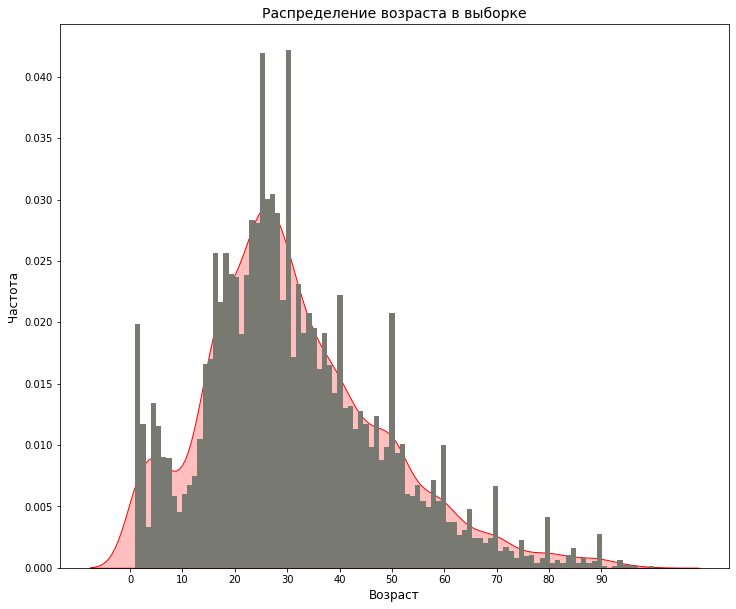

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [7]:
labels['real_age'].hist(bins=100, grid=False, figsize=(12,10), density=True)
plt.title('Распределение возраста в выборке', fontsize=14)
sns.distplot(labels['real_age'], rug=False, kde_kws={'shade':True, 'color':'r'}, bins=100)
plt.xlabel('Возраст', fontsize=12)
plt.xticks(np.arange(0, 100, step=10)) 
plt.ylabel('Частота', fontsize=12)
plt.show()
labels['real_age'].describe()

* В данных представлены самые разные возраста от 1 года до 100 лет.
* Медиана на 29 годах.
* Заметны пики для разных возрастных групп. Наибольшие значения в группах находятся у круглых дат, как 30,40,50 и т.д. Таким образом, большую часть возрастных категорий будут определяться вокруг круглых дат.
* Тем не менее, есть данные и вокруг круглых дат. 
* Данные выглядят правдоподобно.
* Однако значений около 90-100 лет крайне мало и возможно будет недостаточно для обучения модели.
* Далее импортируем данные с изображениями.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/MyDrive/Colab Notebooks/ResNet50/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


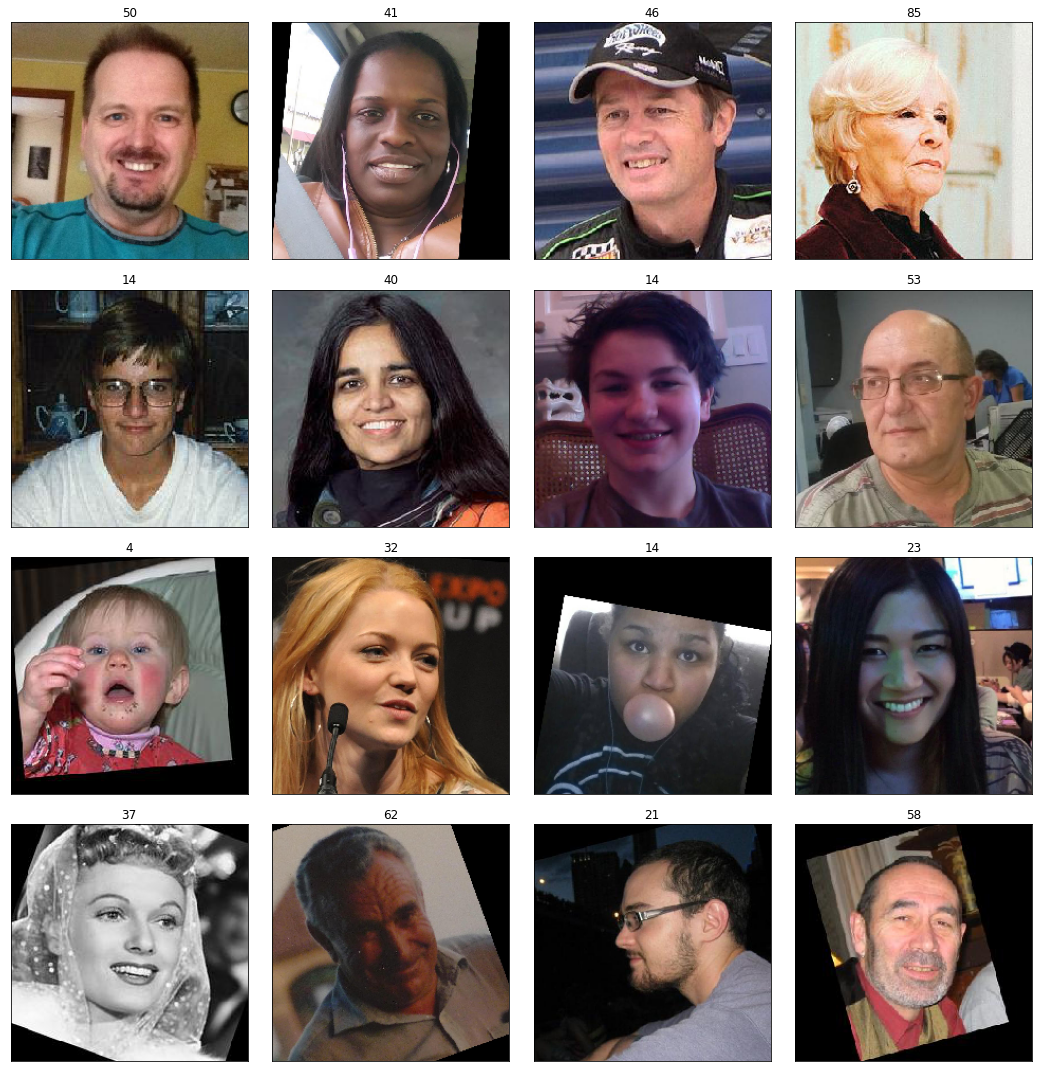

In [9]:
#Выведим значения изображений из первого батча тренировочной выборки
features, target = next(train_gen_flow)

# Выведем 16 рандомных изображений из первого батча тренировочной выборки
fig = plt.figure(figsize=(15,15))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
  # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

* Возрасты на рандомных 16 фото соответствуют изображениям.
* Представлены как цветные, так и чёрно-белые фото.
* Фото разного качества, некоторые фотографии имеют повернутый угол - центрированы.

## Построение и обучение модели

Построим функции для загрузки данных, построения и обучения модели.

In [10]:
# Загрузим данные тренировочного датасета
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True, # Добавим аугментацию
    vertical_flip=True)
  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return train_datagen_flow
 
# Загрузим данные тестового датасета
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return test_datagen_flow
 
# Построим модель
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
               metrics=['mae'])
    return model
 
# Построим функцию для обучения модели.
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=1, 
              shuffle=True)
 
    return model

In [11]:
# Получим тренировочные и тестовые данные
#path = '../input/appa-real-face-cropped/'
path = '/content/drive/MyDrive/Colab Notebooks/ResNet50/'
train_data = load_train(path)
test_data = load_test(path)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [12]:
# Создадим модель
model = create_model(input_shape = (224, 224, 3))

In [13]:
# Обучим модель на 20 эпохах
history = train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None)

Epoch 1/20
178/178 [==============================] - 1148s 6s/step - loss: 240.0378 - mae: 11.3234 - val_loss: 792.6707 - val_mae: 23.2385
Epoch 2/20
178/178 [==============================] - 77s 430ms/step - loss: 107.6454 - mae: 7.8017 - val_loss: 631.7324 - val_mae: 20.0834
Epoch 3/20
178/178 [==============================] - 78s 440ms/step - loss: 76.2685 - mae: 6.5922 - val_loss: 322.5440 - val_mae: 13.6237
Epoch 4/20
178/178 [==============================] - 78s 437ms/step - loss: 66.2249 - mae: 6.0928 - val_loss: 154.2820 - val_mae: 9.3089
Epoch 5/20
178/178 [==============================] - 78s 437ms/step - loss: 54.1708 - mae: 5.5575 - val_loss: 169.3785 - val_mae: 10.1824
Epoch 6/20
178/178 [==============================] - 78s 439ms/step - loss: 47.4981 - mae: 5.1781 - val_loss: 84.8095 - val_mae: 7.0393
Epoch 7/20
178/178 [==============================] - 79s 441ms/step - loss: 40.9930 - mae: 4.8614 - val_loss: 82.3006 - val_mae: 6.6106
Epoch 8/20
178/178 [==========

In [16]:
# Сохраним модель
#model.save("rps.h5")
model.save("/content/drive/MyDrive/Colab Notebooks/ResNet50/rps.h5")

## Предсказание модели

In [17]:
# Загрузим обученную модель
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ResNet50/rps.h5')

In [18]:
# Получим батч из 32 фотографий и возрастов из тестовой выборки
features_test, target_test = next(test_data) 

In [19]:
# Получим предсказание модели
predicted = model.predict(features_test)

In [20]:
# Посмотрим на реальный и предсказанный возраст 32 людей из батча 
real_age = pd.DataFrame(target_test, columns=['Реальный возраст'])
predicted_age = pd.DataFrame(round(pd.DataFrame(predicted, columns=['Предсказаный возраст'])).astype('int'))

real_age.merge(predicted_age, how='inner', left_index=True, right_index=True)

,Реальный возраст,Предсказаный возраст
0,63,60
1,15,18
2,25,20
3,40,27
4,43,34
5,50,43
6,21,19
7,18,26
8,40,32
9,43,42


* Видны расхождения в предсказании модели.
* Посмотрим на сами фотографии людей.

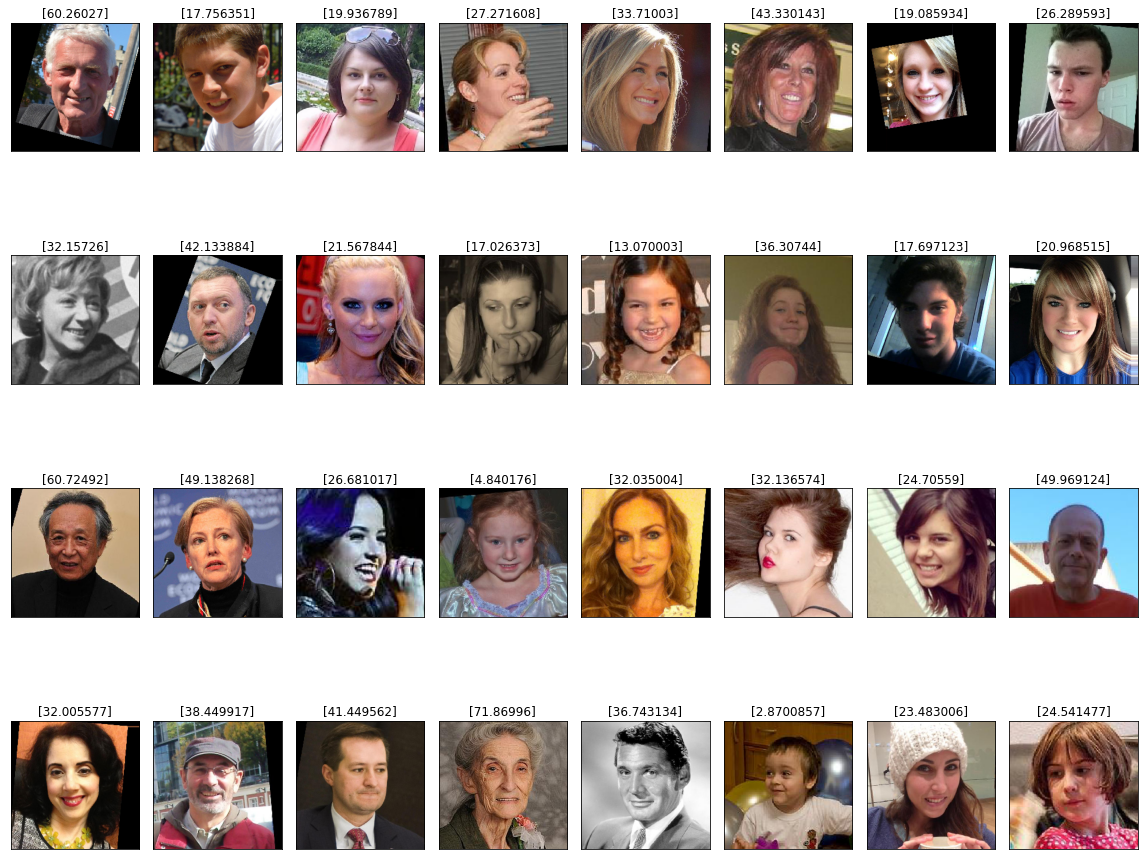

In [21]:
# Посмотрим на предсказанный возраст на фотографиях
fig = plt.figure(figsize=(16,16))
for i in range(len(model.predict(features_test))):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features_test[i])
    plt.title(f'{model.predict(features_test)[i]}')
  # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

* Можно заметить, что модель имеет расхождения для возрастных групп, которые реже представлены в выборке.
* Однако для 20-летних возраст предсказывается довольно точно.

## Вывод

* Построена модель ResNet50 на предобученной выборке `imagenet`. Был добавлен один дополнительный слой `model.add(Dense(64, activation='relu'))` для повышения точности предсказания модели.
* Точность предсказания тестовой выборки составила, оцененая по метрике `MAE` составила 6.23, что лучше ожидаемой метрики заказчика в 8.
* Таким образом, построенная модель позволяет предсказать возраст с точностью ±6,2 года. 